<a href="https://colab.research.google.com/github/ravi-gopalan/DAND_Data_Wrangling/blob/master/fastai_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classifier Model Creation / Refresh

# Mount Google Drive to load the files

## FastAI requires GPU resources for optimal performance. Images for training the Image Classifier model have been loaded onto Google Drive  

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


# Import the libraries onto the Jupyter notebook

The ```InteractiveShell.ast_node_interactivity = 'all'``` setting ensures visibility into multiple outputs for each cell

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## The libraries required are the following

- ```fastai``` and ```fastai.vision``` for image model building
- ```numpy``` and ```pandas``` for vector operations
- ```os``` and ```time``` for general processing

In [0]:
from fastai import *
from fastai.vision import *

import numpy as np
import pandas as pd
import os
import time

# Setup the directories where the images are stored

The images in the ```image_dir``` folder has the following structure. This makes it easy to create the data for processing

```
image_dir
│
└───train   
│   └───approved
│   │    │   image1.jpg
│   │    │   ...
│   │
│   └───ineligible
│   │    │   image1.jpg
│   │    │   ...
│   
└───valid   
│   └───approved
│   │    │   image1.jpg
│   │    │   ...
│   │
│   └───ineligible
│   │    │   image1.jpg
│   │    │   ...
│   
└───test   
│   └───approved
│   │    │   image1.jpg
│   │    │   ...
│   │
│   └───ineligible
│   │    │   image1.jpg
│   │    │   ...
```

In [0]:
image_dir = '/gdrive/My Drive/abv_reviews/images'
# The predict_dir has some images which are currently in the pending stage for inference 
predict_dir = '/gdrive/My Drive/abv_reviews/pending_images/pending/'

In [5]:
# Number of files in the train, valid, and test folder and sub-folders
print('Train: Approved {}, Ineligible {}'.format(len(os.listdir(image_dir+'/train/approved')), len(os.listdir(image_dir+'/train/ineligible'))))
print('Valid: Approved {}, Ineligible {}'.format(len(os.listdir(image_dir+'/valid/approved')), len(os.listdir(image_dir+'/valid/ineligible'))))
print('Test: Approved {}, Ineligible {}'.format(len(os.listdir(image_dir+'/test/approved')), len(os.listdir(image_dir+'/test/ineligible'))))

Train: Approved 1015, Ineligible 206
Valid: Approved 218, Ineligible 44
Test: Approved 225, Ineligible 45


# Create Databunch for fastai

In [6]:
data = (ImageList.from_folder(image_dir)
        .split_by_folder()          
        .label_from_folder()
        .transform(get_transforms(do_flip=False), size=224)
        .databunch(bs=32)
        .normalize(imagenet_stats))

# The classes of the data are approved and ineligible
len(data.classes)

2

# Create a Learner

The resnet34 pre-trained model is used and will be downloaded. 

The metrics to be optimized are ```error_rate, accuracy, precision, recall and FBeta```

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 24.7MB/s]


epoch,train_loss,valid_loss,error_rate,accuracy,recall,precision,f_beta,time
0,1.054034,0.742055,0.248092,0.751908,0.669516,0.622100,0.651001,06:17
1,0.757633,0.609044,0.217557,0.782443,0.651585,0.631263,0.646185,01:40


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


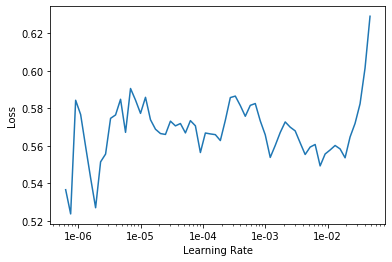

In [7]:
learn_resnet34 = cnn_learner(data, models.resnet34, metrics=[error_rate,accuracy, Recall(average='macro'), Precision(average='macro'),FBeta(average='macro')])

# Fit for 2 cycles
learn_resnet34.fit_one_cycle(2)

# Save the model generated as stage_1_resnet34
learn_resnet34.save('stage_1_resnet34')

# Find out learning rate
learn_resnet34.lr_find()

# Plot learning rate. This will enable us to determine the best learning rate for further training.
learn_resnet34.recorder.plot()



# Model Training

In [8]:
# Unfreeze the resnet34 model

learn_resnet34.unfreeze()

# Run the training for 20 cycles for the best learning rate that was determined in the previous step
learn_resnet34.fit_one_cycle(5, max_lr = slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,recall,precision,f_beta,time
0,0.464352,0.523698,0.175573,0.824427,0.676814,0.683550,0.678076,01:41
1,0.407020,0.489641,0.183206,0.816794,0.608736,0.649856,0.612930,01:42
2,0.348416,0.502347,0.160305,0.839695,0.649708,0.706322,0.656131,01:41
3,0.288149,0.495162,0.148855,0.851145,0.674729,0.734046,0.682033,01:40
4,0.226045,0.496182,0.152672,0.847328,0.672435,0.724728,0.679141,01:41


## Save the model as stage_2_resnet34

In [0]:
learn_resnet34.save('stage_2_resnet34')

In [0]:
learn_resnet34.export()

# Interpretation of the model's results

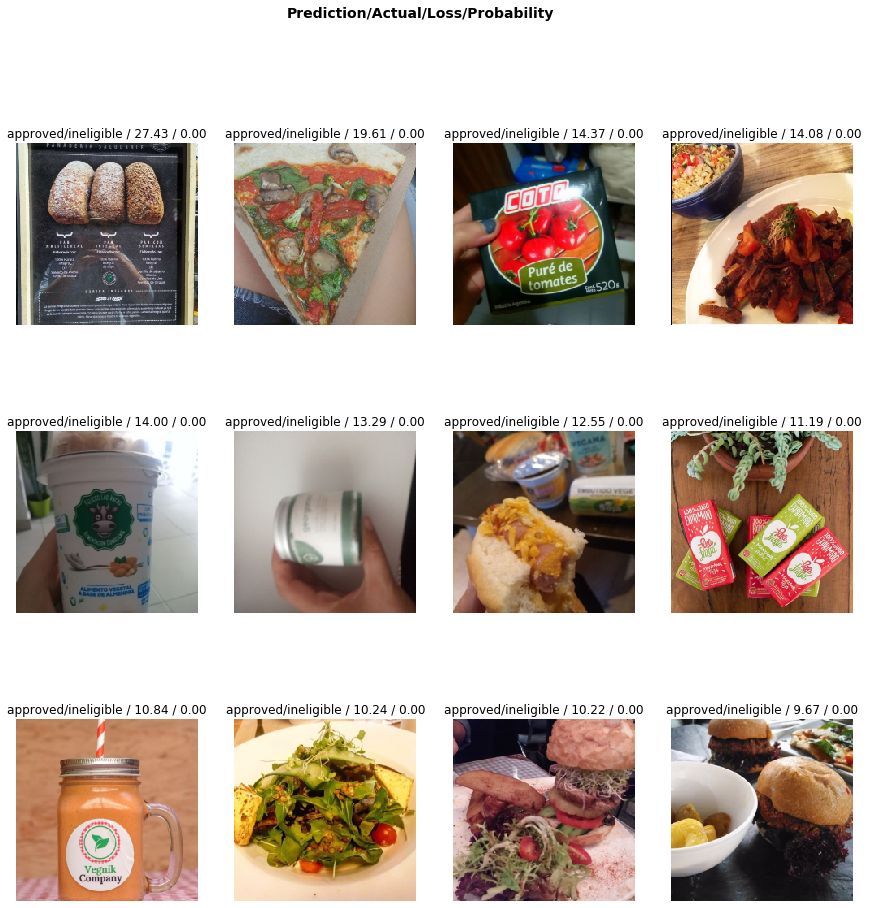

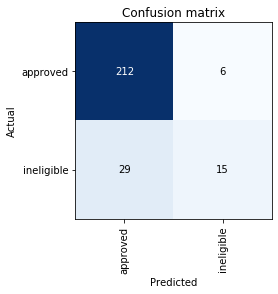

In [0]:
# Interpret the model that has been generated and then identify the images for which the loss is the highest

interp_resnet34 = ClassificationInterpretation.from_learner(learn_resnet34)
interp_resnet34.plot_top_losses(12, figsize=(15,15))


# Plot the confusion matrix that visually represents the model's accuracy, precision and recall
interp_resnet34.plot_confusion_matrix()

# Interpret results

The model provided an accuracy of ~86% with recall of 66% and precision of 80%

The issues here relate to the fact that some of the pictures are products and not dishes and those need separate training. There are also some images which are pictures of menu cards. These need to be addressed separately.

The confusion matrix indicates that the model classified 212 test images correctly as approved and 15 correctly as ineligible

The model also predicted 29 of the images as approved while they were ineligible and 6 images as ineligible while they were in fact approved.

# Predict

Use the model to classify images that are currently in the pending category 

In [0]:
pending_list = os.listdir(predict_dir)
len(pending_list)

293

## Predict for a random sample of images

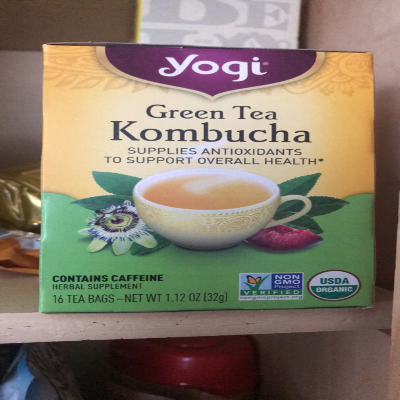

99.81% probability of review being approved 



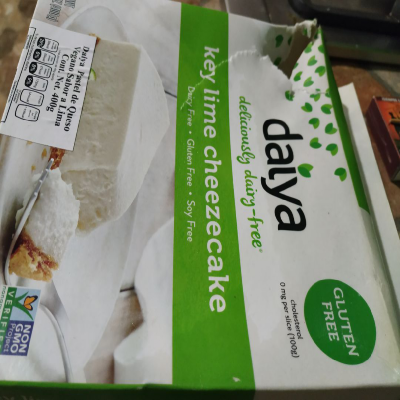

95.83% probability of review being approved 



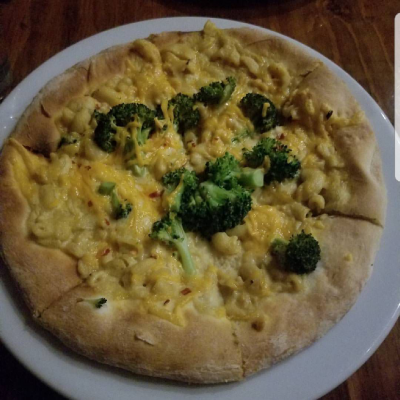

100.00% probability of review being approved 



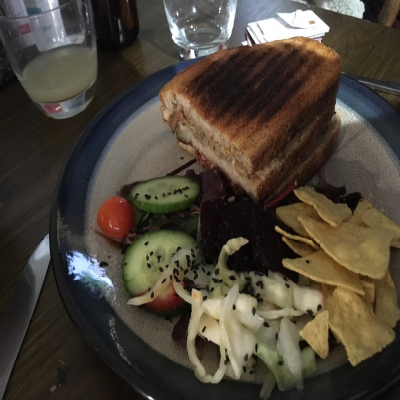

100.00% probability of review being approved 



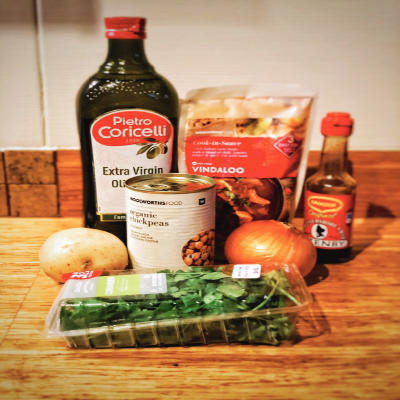

96.38% probability of review being approved 



In [0]:
file_list = [predict_dir+file for file in list(np.random.choice(pending_list, size=5, replace=False))]
for pic in file_list:
  open_image(pic).resize(400)
  predicted_status, tensor_index, probability_tensor = learn_resnet34.predict(open_image(pic).resize(200))
  prob = max(probability_tensor[0].item(),probability_tensor[1].item())
  print('{:.2f}% probability of review being {} \n'.format(100*prob, predicted_status.obj))
  time.sleep(5)